In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib as mpl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 
import imageio
import os
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree


In [2]:
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of CUDA devices: 1
Device 0: Tesla V100-SXM2-32GB


In [4]:
from dask.distributed import Client
client = Client(processes=False)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: False
Comm: inproc://10.6.8.8/182489/1,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 95.00 GiB
Comm: inproc://10.6.8.8/182489/4,Total threads: 12
Dashboard: /proxy/40585/status,Memory: 95.00 GiB
Nanny: None,


In [6]:
matplotlib.rcParams['font.family'] = 'Times New Roman'


In [7]:
print(xgb.__version__)

2.1.3


# Read the data (OISST & Argo)
- uniform the time dim

In [8]:
xgb_merge = xr.open_dataset("/g/data/jk72/yz7014/stf/Step2/xgb_merge.nc")
xgb_merge

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.Dataset> Size: 453MB
Dimensions:  (time: 240, lat: 82, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2023-12-15
  * lat      (lat) float64 656B -50.12 -49.88 -49.62 ... -30.38 -30.12 -29.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float64 227MB ...
    st100    (time, lat, lon) float64 227MB ...

# Flatten the input data into a pd dataframe

- also add the day and year into the pd dataframe

In [9]:
def flatten_day(data):
    """
    Flattens the data into a pd dataframe
    Add a day column and a year column to the data
    Delete the time column
    
    Parameters:
    -----------
    data1: xarray dataset
        The first dataset to be flattened
    data2: xarray dataset
        The second dataset to be flattened
    
    return: pd dataframe
        The flattened pd dataframe
    """

    pd_data = data.to_dataframe().reset_index()

    base_date = pd.to_datetime('2004-01-01')
    
    pd_data['day'] = (pd_data['time'] - base_date).dt.days

    pd_data['year'] = pd_data['time'].dt.year

    pd_data = pd_data.drop(columns = ['time'])

    return pd_data

# Split the training and testing data
- Randomly split the training and testing data by year
- Delete NaN data

In [10]:
def training_testing_split(data):
    """
    Split the data into training and testing data
    
    Parameters:
    -----------
    data: pd dataframe
        The data to be split
    
    return: pd dataframe, pd dataframe
        The training and testing data
    """
    years = list(range(2004, 2024))
    shuffled_years = pd.Series(years).sample(frac=1).tolist()
    training_years = shuffled_years[:15]
    testing_years = shuffled_years[15:]

    training_data = data[data['year'].isin(training_years)].dropna()
    testing_data = data[data['year'].isin(testing_years)].dropna()


    training_X = training_data.drop(columns = ['st100', 'year'], axis = 1)
    training_y = training_data['st100']
    testing_X = testing_data.drop(columns = ['st100', 'year'], axis = 1)
    testing_y = testing_data['st100']
    print('Training years: ', training_years)
    print('Testing years: ', testing_years)
    return training_X, testing_X, training_y, testing_y, training_years, testing_years

# XGBoost build

In [11]:
def run_model(xgb_reg, training_X, testing_X, training_y, testing_y):
    """
    Train the model and return the model and the prediction
    
    Parameters:
    -----------
    xgb_reg: xgboost model
        The xgboost model to be trained
    training_X: pd dataframe
        The training data
    testing_X: pd dataframe
        The testing data
    training_y: pd dataframe
        The training label
    testing_y: pd dataframe
        The testing label
    
    return: xgboost model, np array
        The trained model and the prediction
    """
    
    
    xgb_model = xgb_reg.fit(training_X, training_y)
    y_pred = xgb_reg.predict(testing_X)
    rmse = np.sqrt(mean_squared_error(testing_y, y_pred))
    r2 = r2_score(testing_y, y_pred)
    print('RMSE: ', rmse)
    print('R^2: ', r2)

    return y_pred, xgb_model

In [12]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 400,
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.55,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device' : 'cuda'
}

In [13]:
pd_xgb_data = flatten_day(xgb_merge)
training_X, testing_X, training_y, testing_y, training_years, testing_years = training_testing_split(pd_xgb_data)

Training years:  [2013, 2016, 2022, 2018, 2007, 2015, 2011, 2021, 2020, 2005, 2010, 2012, 2023, 2006, 2008]
Testing years:  [2014, 2017, 2004, 2009, 2019]


In [14]:
xgb_reg = xgb.XGBRegressor(**params, seed = 42)
y_pred, xgb_model = run_model(xgb_reg, training_X, testing_X, training_y, testing_y)

/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:24:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


RMSE:  0.6734219337307177
R^2:  0.9739151478695506


# Tuning


In [15]:
def tuning_function(alg, param_test, training_X, training_y):
    """
    Tune the hyperparameters of the model
    
    Parameters:
    -----------
    alg: xgboost model
        The xgboost model to be trained
    param_test: dict
        The hyperparameters to be tuned
    training_X: pd dataframe
        The training data
    training_y: pd dataframe
        The training label
    
    return: dict
        The best hyperparameters
    """
    gsearch = GridSearchCV(estimator = alg, 
                           param_grid = param_test, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1,
                           verbose=1,
                           cv=4)
    
    gsearch.fit(training_X, training_y)

    print("Best parameters found: ", gsearch.best_params_)
    print("Lowest RMSE found: ", np.sqrt(np.abs(gsearch.best_score_)))

    new_params = alg.get_xgb_params()
    for key in gsearch.best_params_.keys():
        new_params[key] = gsearch.best_params_[key]

    alg = xgb.XGBRegressor(**new_params)

    return alg, gsearch.cv_results_

In [16]:
def plot_gridsearch(grid, results, folds=4):

    x = np.arange(0,len(results['params']))

    fig = plt.figure(figsize=(16,4))
    ax = plt.subplot(111)
    cols=sns.color_palette("cubehelix",folds)

    for i in range(4):  

        plt.scatter(x=x,y=results['split{}_test_score'.format(i)],
                        color=cols[i],edgecolor='grey',s=50,
                        alpha=0.5,label='Fold {}'.format(i+1))
        plt.plot(x,results['split{}_test_score'.format(i)],
                 color=cols[i])

    plt.scatter(x=x,y=results['mean_test_score'],
                    color='black',edgecolor='grey',s=50,
                    alpha=0.5,label='Mean')
    plt.plot(x,results['mean_test_score'],
             color='black')

    plt.ylabel('RMSE')

    k = list(results['params'][0].keys())
    if len(k) > 1: 
        labels = ['{}:{} \n {}:{}'.format(k[0],
                                            results['params'][i][k[0]],
                                            k[1],
                                            results['params'][i][k[1]],
                                           ) for i in range(len(results['params']))]

        plt.xlabel('Parameters')
        plt.xticks(x, labels,rotation=90)
    else:
        plt.xlabel(k[0])
        plt.xticks(x, grid[k[0]])

    plt.legend()

In [17]:
grid_0 = {'n_estimators': [250, 300, 350, 400, 450, 500, 550]}

xgb_reg, cv_results_0 = tuning_function(xgb_reg, grid_0, training_X, training_y)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:26:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:26:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Best parameters found:  {'n_estimators': 400}
Lowest RMSE found:  0.7410074318377294


In [18]:
cv_results_0

{'mean_fit_time': array([123.8124308 , 147.12763989, 168.52794838, 189.55773515,
        213.23251903, 223.11531538, 133.47023851]),
 'std_fit_time': array([1.60450769, 0.17955575, 0.07116237, 0.35245012, 0.35443952,
        0.04946625, 1.29467501]),
 'mean_score_time': array([0.98251164, 1.27802408, 1.61232513, 1.26967865, 1.51111168,
        1.77681297, 1.00374901]),
 'std_score_time': array([0.00824575, 0.08066983, 0.03051429, 0.03607006, 0.15167754,
        0.04746256, 0.06173384]),
 'param_n_estimators': masked_array(data=[250, 300, 350, 400, 450, 500, 550],
              mask=[False, False, False, False, False, False, False],
        fill_value=999999),
 'params': [{'n_estimators': 250},
  {'n_estimators': 300},
  {'n_estimators': 350},
  {'n_estimators': 400},
  {'n_estimators': 450},
  {'n_estimators': 500},
  {'n_estimators': 550}],
 'split0_test_score': array([-0.58470567, -0.51512246, -0.49063444, -0.48597882, -0.48759512,
        -0.49028474, -0.49408429]),
 'split1_test_sc

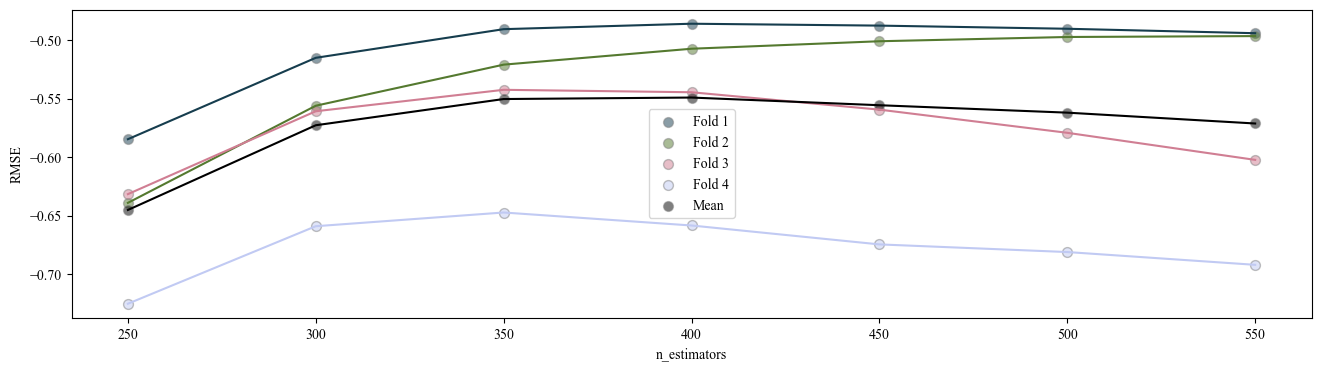

In [19]:
plot_gridsearch(grid_0, cv_results_0)

In [20]:
grid_1 = {'n_estimators': [380, 390, 400, 410, 420]}

xgb_reg, cv_results_1 = tuning_function(xgb_reg, grid_1, training_X, training_y)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 380}
Lowest RMSE found:  0.7404315995627202


In [21]:
cv_results_1

{'mean_fit_time': array([182.86011153, 187.86676848, 191.6807186 , 132.80803299,
        132.80679232]),
 'std_fit_time': array([2.56481557, 0.132215  , 1.04459368, 0.6300121 , 0.09955657]),
 'mean_score_time': array([1.18144649, 1.55205911, 1.11284173, 0.95769805, 1.20654386]),
 'std_score_time': array([0.03671601, 0.06797206, 0.11678351, 0.0729634 , 0.14110108]),
 'param_n_estimators': masked_array(data=[380, 390, 400, 410, 420],
              mask=[False, False, False, False, False],
        fill_value=999999),
 'params': [{'n_estimators': 380},
  {'n_estimators': 390},
  {'n_estimators': 400},
  {'n_estimators': 410},
  {'n_estimators': 420}],
 'split0_test_score': array([-0.48639806, -0.48586681, -0.48597882, -0.48598493, -0.4862564 ]),
 'split1_test_score': array([-0.51144323, -0.50901843, -0.50736129, -0.5058097 , -0.50449572]),
 'split2_test_score': array([-0.5426216 , -0.54390484, -0.54456006, -0.54694533, -0.54912848]),
 'split3_test_score': array([-0.65249293, -0.6564586 , -

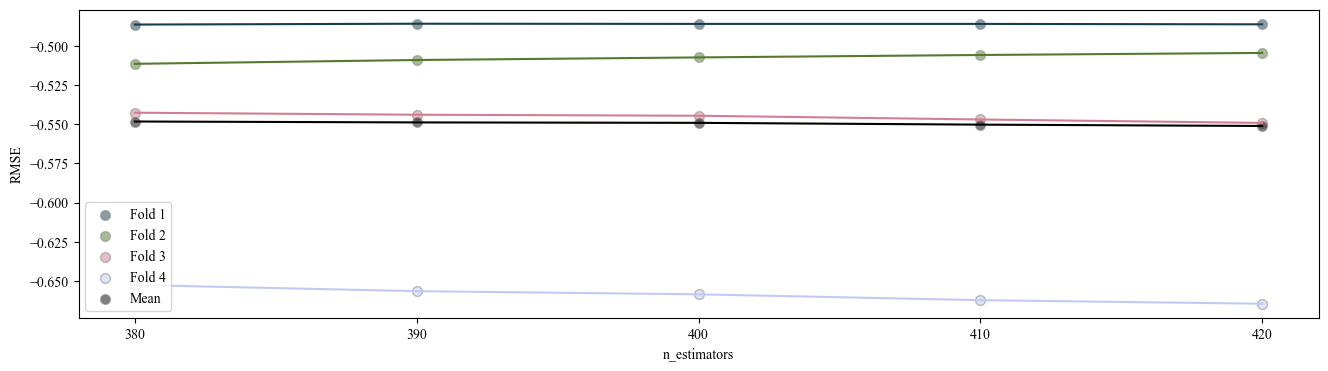

In [22]:
plot_gridsearch(grid_1, cv_results_1)

In [23]:
# max depth and min child weight

grid_2 = { 'max_depth': [7,8,9,10,11],
                 'min_child_weight': [7,9,11,13,15,17,19]}
xgb_reg, results_2 = tuning_function(xgb_reg, grid_2, training_X, training_y)

Fitting 4 folds for each of 35 candidates, totalling 140 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:06:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'max_depth': 11, 'min_child_weight': 15}
Lowest RMSE found:  0.7354009764875479


In [24]:
results_2

{'mean_fit_time': array([ 93.98330456,  95.68920666,  95.85831159,  82.90773189,
         94.62569571,  94.96535766,  88.55158758, 110.87278068,
        111.51759368, 106.02168292, 111.25286281, 112.1125291 ,
        107.87346983, 109.88376731, 138.72820342, 136.79046524,
        137.08635634, 137.9379499 , 136.51074904, 136.52894622,
        135.89155173, 183.36024237, 181.08615285, 181.42904109,
        181.43122715, 181.27299666, 179.72703725, 172.11983508,
        262.27483582, 258.58108944, 251.34129035, 252.12189609,
        252.06549174, 221.38108796, 133.9952814 ]),
 'std_fit_time': array([ 1.61815225,  0.19144883,  0.49070056, 12.97625652,  0.41635371,
         0.66711739,  3.25944695,  0.62205107,  0.31868523,  0.50033185,
         1.86916751,  0.55497618,  0.17901574,  1.14214885,  0.50810647,
         0.31624716,  0.08646361,  0.30631871,  0.05422877,  0.11536632,
         0.257811  ,  1.21907678,  0.05265042,  1.59230271,  2.87194189,
         0.9832787 ,  0.41539136,  1.0

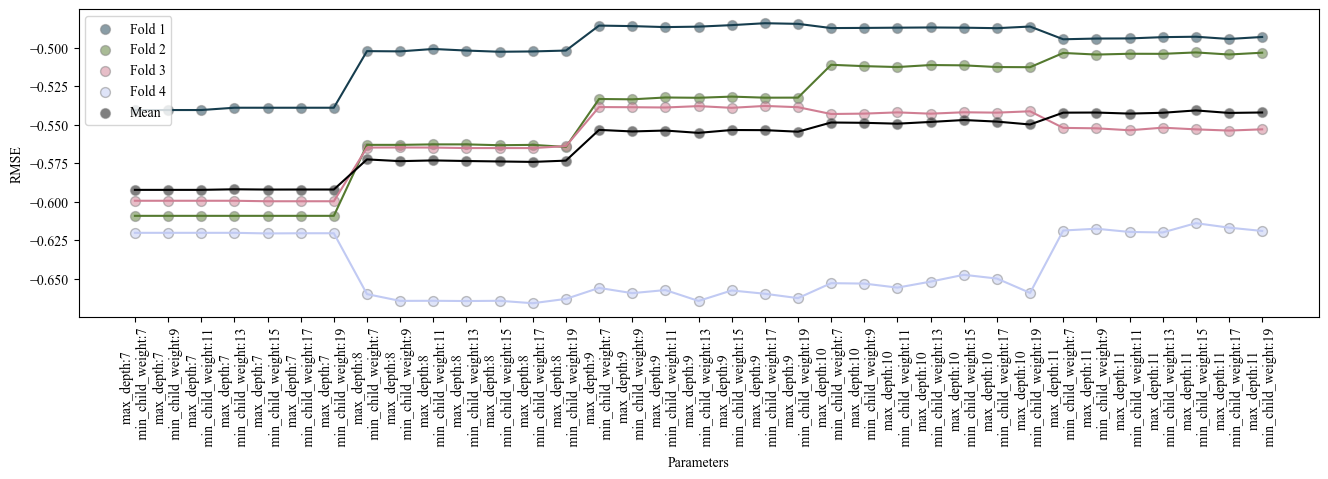

In [25]:
plot_gridsearch(grid_2, results_2)

In [29]:
# gamma

grid_3 = {'gamma': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]}
xgb_reg, results_3 = tuning_function(xgb_reg, grid_3, training_X, training_y)


Fitting 4 folds for each of 7 candidates, totalling 28 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:13:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:13:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Best parameters found:  {'gamma': 0.08}
Lowest RMSE found:  1.6668810715845988


In [30]:
results_3

{'mean_fit_time': array([71.73021013, 73.26578665, 72.8103438 , 63.67023575, 72.71912372,
        72.56652528, 28.42666811]),
 'std_fit_time': array([1.09192511, 0.18953972, 0.23604189, 9.62913975, 0.4407522 ,
        0.13330777, 7.42668324]),
 'mean_score_time': array([1.05057317, 0.86262625, 0.64805675, 1.15856791, 0.85504347,
        0.77648342, 0.55952603]),
 'std_score_time': array([0.09402986, 0.06762621, 0.13095596, 0.030628  , 0.07498129,
        0.04142895, 0.08553064]),
 'param_gamma': masked_array(data=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'gamma': 0},
  {'gamma': 0.02},
  {'gamma': 0.04},
  {'gamma': 0.06},
  {'gamma': 0.08},
  {'gamma': 0.1},
  {'gamma': 0.12}],
 'split0_test_score': array([-2.71183024, -2.71128605, -2.71137755, -2.71169775, -2.71183295,
        -2.71181841, -2.71184228]),
 'split1_test_score': array([-2.83918297, -2.83896418, -2.83897313, -2.8

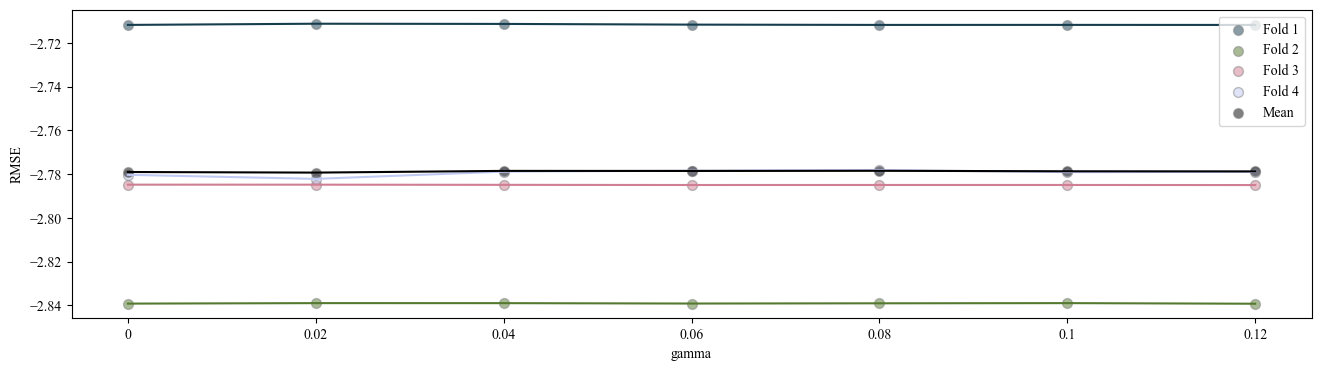

In [31]:
plot_gridsearch(grid_3, results_3)

In [34]:
# learning rate

grid_4 = {'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.07, 0.09, 0.11]}
xgb_reg, results_4 = tuning_function(xgb_reg, grid_4, training_X, training_y)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:25:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:25:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Best parameters found:  {'learning_rate': 0.03}
Lowest RMSE found:  0.7472459888594508


In [36]:
results_4

{'mean_fit_time': array([72.47214043, 73.56322217, 73.54773033, 63.24933577, 66.8980158 ,
        66.11071432, 21.64767241]),
 'std_fit_time': array([0.76878266, 0.14264166, 0.12156017, 4.58228652, 0.35694825,
        0.15246802, 2.11362177]),
 'mean_score_time': array([1.04568845, 0.64157122, 0.70091534, 0.93522483, 0.84297484,
        0.87216413, 0.54524589]),
 'std_score_time': array([0.09759394, 0.10989539, 0.04637341, 0.19173782, 0.14198246,
        0.06035591, 0.04883643]),
 'param_learning_rate': masked_array(data=[0.005, 0.01, 0.03, 0.05, 0.07, 0.09, 0.11],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'learning_rate': 0.005},
  {'learning_rate': 0.01},
  {'learning_rate': 0.03},
  {'learning_rate': 0.05},
  {'learning_rate': 0.07},
  {'learning_rate': 0.09},
  {'learning_rate': 0.11}],
 'split0_test_score': array([-6.65257247, -2.71183295, -0.51590963, -0.50086234, -0.52458654,
        -0.53528977, -0.54581725]),


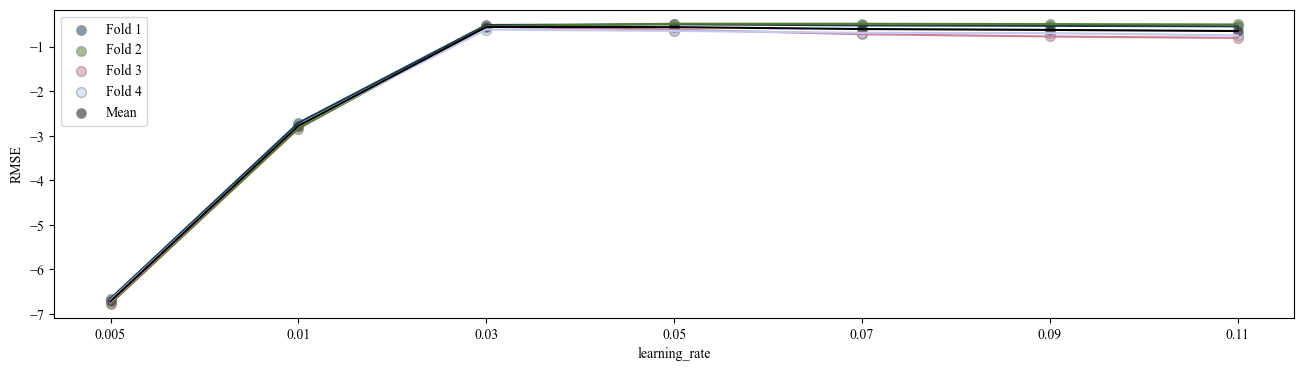

In [37]:
plot_gridsearch(grid_4, results_4)

In [41]:
# learning rate

grid_5 = {'learning_rate': [0.02, 0.025, 0.03, 0.035, 0.04, 0.045]}
xgb_reg, results_5 = tuning_function(xgb_reg, grid_5, training_X, training_y)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:57:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:57:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Best parameters found:  {'learning_rate': 0.04}
Lowest RMSE found:  0.7355351657197341


In [42]:
results_5

{'mean_fit_time': array([71.72542024, 72.88139755, 72.67408293, 66.387317  , 69.55141658,
        69.33173561]),
 'std_fit_time': array([0.66150653, 0.02403627, 0.08510202, 2.76988023, 0.10778878,
        0.02164493]),
 'mean_score_time': array([0.96787328, 0.71672064, 0.80464321, 0.94094825, 0.65499473,
        0.80696303]),
 'std_score_time': array([0.19746551, 0.11944769, 0.13037758, 0.18649515, 0.08836821,
        0.08827559]),
 'param_learning_rate': masked_array(data=[0.02, 0.025, 0.03, 0.035, 0.04, 0.045],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'learning_rate': 0.02},
  {'learning_rate': 0.025},
  {'learning_rate': 0.03},
  {'learning_rate': 0.035},
  {'learning_rate': 0.04},
  {'learning_rate': 0.045}],
 'split0_test_score': array([-0.7691302 , -0.57921687, -0.51590963, -0.49453266, -0.49443949,
        -0.49689141]),
 'split1_test_score': array([-0.82364987, -0.61933765, -0.54190282, -0.50877253, -0.4983259 ,
    

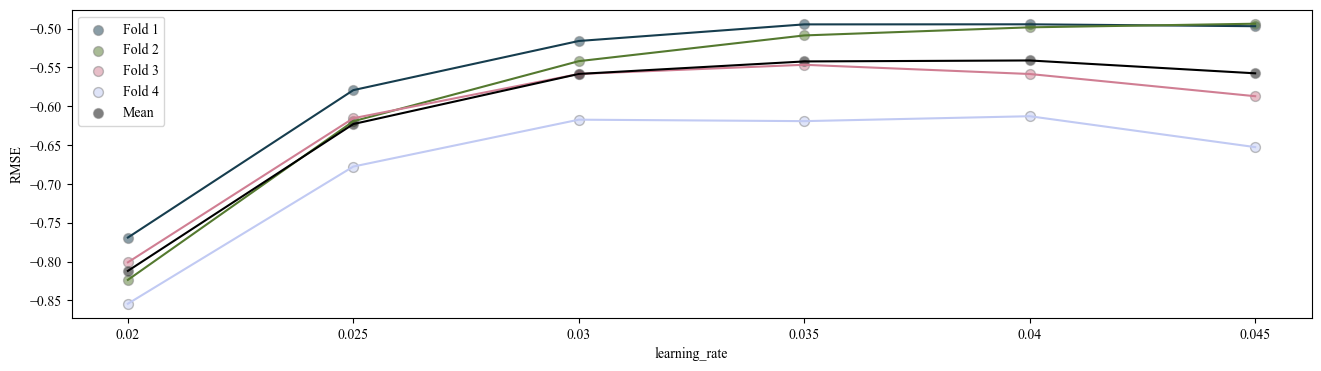

In [43]:
plot_gridsearch(grid_5, results_5)

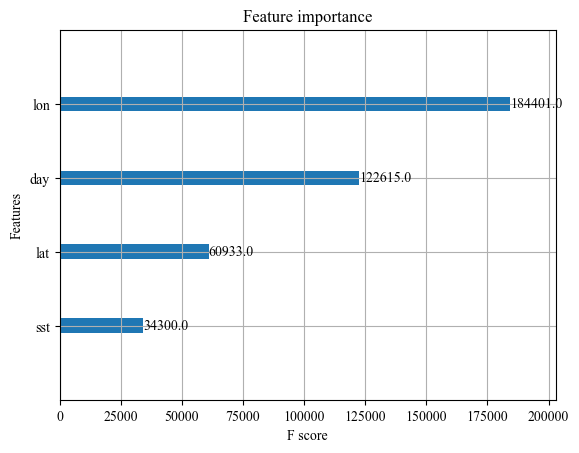

In [32]:
plot_importance(xgb_model)
plt.show()

In [44]:
params = {
    'learning_rate': 0.04,
    'n_estimators': 390,
    'max_depth': 11,
    'min_child_weight': 15,
    'subsample': 0.55,
    'gamma': 0.08,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device' : 'cuda'
}

In [45]:
xgb_reg = xgb.XGBRegressor(**params, seed = 42)
y_pred, xgb_model_tuning = run_model(xgb_reg, training_X, testing_X, training_y, testing_y)

RMSE:  0.7690417133389201
R^2:  0.9659816176672904


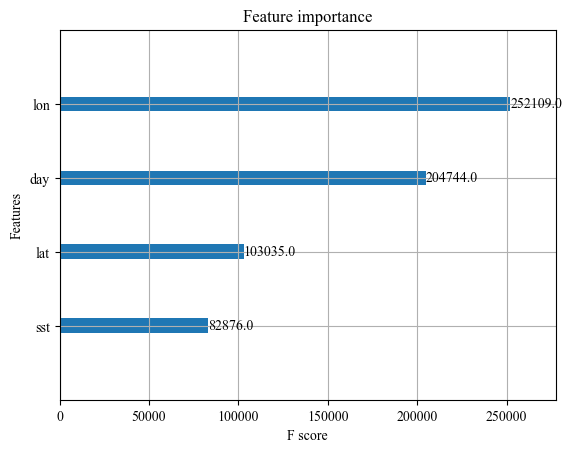

In [46]:
plot_importance(xgb_model_tuning)
plt.show()